# weblogs parser

This notebook analyses data from weblogs, in this case from an [ERDDAP](https://github.com/ERDDAP/erddap) server. Though ERDDAP keeps its own logs, I use the logs from the  webserver so that this analysis can be applied to a broader range of sites.



In [1]:
from apachelogs import LogParser
from pathlib import Path
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import cartopy
import datetime
import cartopy.crs as ccrs
import requests
import glob
import re
import copy

**NB** To run this against your own logs, add the path to your apache and/or nginx logs in the following cell

In [2]:
apache_logs_dir = "../track-visitors/erddap/2023-03-01_old_apache_logs"
nginx_logs_dir = "../track-visitors/erddap/logs/"

### Parse apache logs

In [3]:
apache_logs = list(Path(apache_logs_dir).glob("*access*"))
parser = LogParser("%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\"")
dt, ip, url = [], [], []
for fn in apache_logs:
    with open(fn) as fp:
        for entry in parser.parse_lines(fp):
            try:
                this_url = entry.request_line.split(" ")[1]
            except:
                this_url = ""
            dt.append(entry.request_time)
            ip.append(entry.remote_host)
            url.append(this_url)
df_pd = pd.DataFrame({"ip": ip, "datetime" : dt, "url": url})
df_pd["datetime"] = pd.to_datetime(df_pd.datetime).dt.tz_localize(None)
df_apache = pl.from_pandas(df_pd)
df_apache = df_apache.sort(by="datetime")
df_pd.describe()

,datetime
count,701350
mean,2022-12-19 21:27:20.297286144
min,2022-09-16 00:02:51
25%,2022-11-19 15:02:14.249999872
50%,2022-12-18 03:59:48.500000
75%,2023-01-21 04:52:26
max,2023-02-28 08:07:26


### Parse nginx logs

In [4]:
# nginx log parser from https://gist.github.com/hreeder/f1ffe1408d296ce0591d
csvs = glob.glob(nginx_logs_dir + "tomcat-access.log*")
lineformat = re.compile(r"""(?P<ipaddress>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - \[(?P<dateandtime>\d{2}\/[a-z]{3}\/\d{4}:\d{2}:\d{2}:\d{2} (\+|\-)\d{4})\] ((\"(GET|POST|HEAD|PUT|DELETE) )(?P<url>.+)(http\/(1\.1|2\.0)")) (?P<statuscode>\d{3}) (?P<bytessent>\d+) (?P<refferer>-|"([^"]+)") (["](?P<useragent>[^"]+)["])""", re.IGNORECASE)
fails = 0
ip, datetimestring, url, bytessent, referrer, useragent, status, method = [], [], [], [],[], [], [], []
for f in csvs:
    if f.endswith(".gz"):
        logfile = gzip.open(f)
    else:
        logfile = open(f)
    for l in logfile.readlines():
        data = re.search(lineformat, l)
        if data:
            datadict = data.groupdict()
            ip.append(datadict["ipaddress"])
            datetimestring.append(datadict["dateandtime"])
            url.append(datadict["url"])
            bytessent.append(datadict["bytessent"])
            referrer.append(datadict["refferer"])
            useragent.append(datadict["useragent"])
            status.append(datadict["statuscode"])
            method.append(data.group(6))

        else:
            fails+=1
    logfile.close()
print(f"failures: {fails/len(ip) * 100 }%")

df_pd = pd.DataFrame({"ip": ip, "datetimestring": datetimestring, "url": url})

# convert timestamp to datetime
df = pl.from_pandas(df_pd)
df = df.with_columns(
    pl.col("datetimestring").str.strptime(pl.Datetime, format="%d/%b/%Y:%H:%M:%S +0000"))
df = df.rename({"datetimestring": "datetime"})
df_nginx = df.sort(by="datetime")


failures: 0.382488929119743%


### Fix datetime to miscoseconds to combine two dataframes

In [5]:
s = df_apache.select("datetime")[:,0]
seconds = (s.cast(int) // 1_000).cast(pl.Datetime).dt.cast_time_unit("us")
df_apache.drop("datetime")
df_apache = df_apache.with_columns(pl.Series(name="datetime", values=seconds))

In [6]:
df_combi = pl.concat(
    [
        df_apache,
        df_nginx,
    ],
    how="vertical",)
df_combi = df_combi.sort("datetime")

### use ip-api.com to fetch IP info

This API is rate limited. We request the most visited ips first and save the results. With subsequent runs, we extend the number of known ips

In [7]:
df_pd = df_combi.to_pandas()

ip_counts = Counter(df_pd.ip).most_common()
print(f"found {len(ip_counts)} unique visitors")
if Path("ip.csv").exists():
    df_ip = pd.read_csv("ip.csv")
else:
    df_ip = pd.DataFrame({"query": [None]})
for ip, count in ip_counts:
    if ip not in df_ip["query"].values:
        resp_raw = requests.get(f"http://ip-api.com/json/{ip}")
        if resp_raw.status_code == 429:
            print("Exceeded API responses. Wait a minute and try again")
            break
        resp = resp_raw.json()
        print(f"New ip identified: {ip} in {resp['country']}. Visited {count} times")
        df_ip = pd.concat((df_ip, pd.DataFrame(resp, index=[0])), ignore_index=True)
df_ip.to_csv("ip.csv", index=False)
print(f"We have info on {len(df_ip)} ip address")


found 21076 unique visitors
New ip identified: 54.36.149.21 in France. Visited 334 times
New ip identified: 54.36.149.22 in France. Visited 334 times
New ip identified: 54.36.149.75 in France. Visited 334 times
New ip identified: 54.36.149.49 in France. Visited 334 times
New ip identified: 54.36.148.173 in France. Visited 334 times
New ip identified: 54.36.149.83 in France. Visited 334 times
New ip identified: 54.36.148.188 in France. Visited 334 times
New ip identified: 54.36.148.29 in France. Visited 334 times
New ip identified: 54.36.149.55 in France. Visited 333 times
New ip identified: 54.36.149.3 in France. Visited 333 times
New ip identified: 54.36.149.40 in France. Visited 333 times
New ip identified: 54.36.148.24 in France. Visited 333 times
New ip identified: 54.36.149.50 in France. Visited 333 times
New ip identified: 54.36.148.134 in France. Visited 333 times
New ip identified: 66.249.66.81 in United States. Visited 333 times
New ip identified: 54.36.149.96 in France. Visit

### Combine requests dataframe with ip metadata dataframe

Now we have a dataframe with metadata from ips that have made requests to our ERDDAP

In [8]:
df_pd = pd.merge(df_pd, df_ip, left_on="ip", right_on="query", how="left")

ip_grid = df_pd.ip.str.split(".", expand=True)
ip_root = ip_grid[0] + "." + ip_grid[1]
ip_group = ip_grid[0] + "." + ip_grid[1] + "." +ip_grid[2]
df_pd["ip_root"] = ip_root
df_pd["ip_group"] = ip_group


### Cast to polars for faster processing

In [9]:
df_combi = pl.from_pandas(df_pd).sort("datetime")

### Drop bad requests

Here we remove requests from bots, crawlers and likely spam (e.g. bots trying to find aws credential files)

In [10]:
df = copy.copy(df_combi)
len_pre_scan = len(df)

df = df.with_columns(pl.col("org").fill_null("unknown"))
df = df.with_columns(pl.col("isp").fill_null("unknown"))

for block_org in ["Google", "Crawlers", "SEMrush"]:
    df = df.filter(
    ~pl.col("org").str.contains(block_org)
    )
    df = df.filter(
    ~pl.col("isp").str.contains(block_org)
    )

print(f"Dropped to  {int(len(df)/len_pre_scan * 100)} % of total after drop crawlers")


# Remove spam/attacks
page_counts = Counter(list(df.select("url").to_numpy()[:,0])).most_common()
bad_refs = [".env", "env.", ".php", ".git", "robots.txt", "phpinfo", "/config", "aws", ".xml"]
bad_pages = []
for page, count in page_counts:
    for phrase in bad_refs:
        if phrase in page:
            bad_pages.append(page)
df = df.filter(~pl.col('url').is_in(bad_pages))

print(f"Dropped to  {int(len(df)/len_pre_scan * 100)} % of total after drop spam requests")


# Retain only requests to erddap 

df = df.filter(
    pl.col("url").str.contains("erddap")
)
print(f"Dropped to  {int(len(df)/len_pre_scan * 100)} % of total after drop non-erddap requests")

len_post_scan = len(df)
print(f"Genuine requests are {int(len_post_scan/len_pre_scan * 100)} % of total")
ip_counts = Counter(list(df_apache.select("ip").to_numpy()[:,0])).most_common()

print(f"{len(ip_counts)} unique visitors")

Dropped to  75 % of total after drop crawlers
Dropped to  70 % of total after drop spam requests
Dropped to  67 % of total after drop non-erddap requests
Genuine requests are 67 % of total
9369 unique visitors


In [11]:
reqs = list(df.select("url").to_numpy()[:,0])
relevant_reqs = []
req_types = []
for req in reqs:
    if "static" in req or "favicon" in req or "images" in req:
        continue
    if req=="/ ":
        continue
    if "?" in req:
        req = req.split("?")[0]
    if "." in req:
        req_types.append(req.split(".")[1])
        req = req.split(".")[0]
    relevant_reqs.append(req)

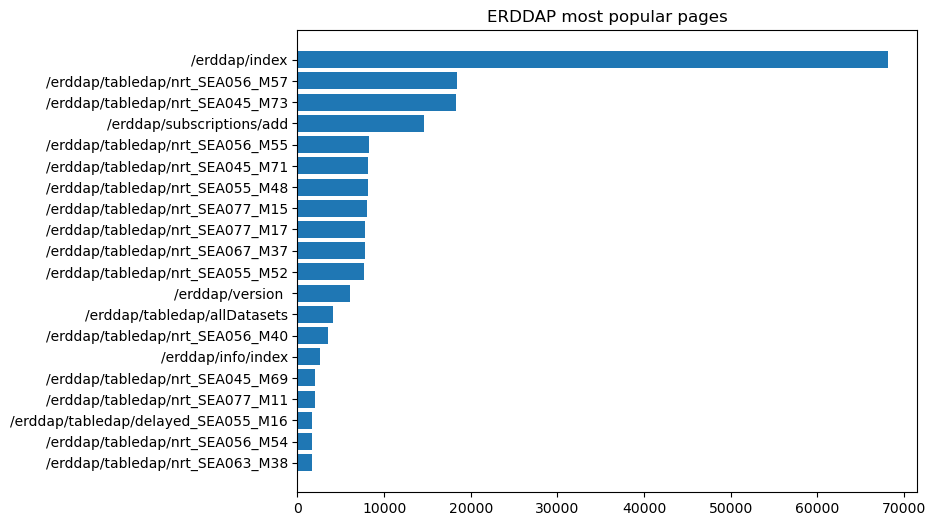

In [12]:
page_counts = Counter(relevant_reqs).most_common()
df_count = pd.DataFrame.from_dict(page_counts[:20])
df_count = df_count.rename({0: "page", 1: "counts"}, axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_count.page, df_count.counts)
ax.set_title("ERDDAP most popular pages")
ax.invert_yaxis()

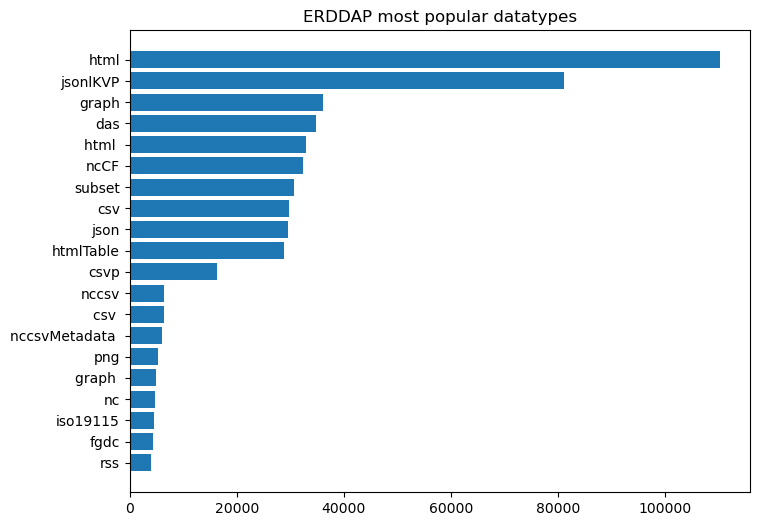

In [13]:
page_counts = Counter(req_types).most_common()
df_count = pd.DataFrame.from_dict(page_counts[:20])
df_count = df_count.rename({0: "page", 1: "counts"}, axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_count.page, df_count.counts)
ax.set_title("ERDDAP most popular datatypes")
ax.invert_yaxis()


In [14]:
visits_by_country = df.group_by("country").count()
visits_by_country = visits_by_country.sort("count").drop_nulls()[-10:]

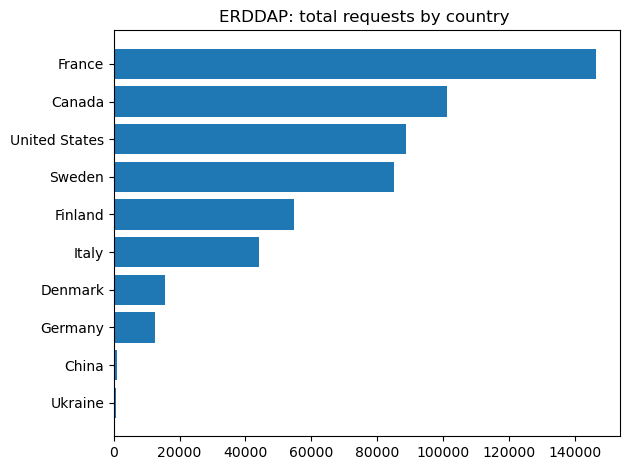

In [15]:
fig, ax = plt.subplots()
ax.barh(visits_by_country[:,0], visits_by_country[:, 1])
ax.set(title="ERDDAP: total requests by country ")
plt.tight_layout()


### Group IPs into geographic areas and plot

In [16]:
ip_group_info = df.group_by("ip_group").first()
visits_by_ip_group = df.group_by("ip_group").count()
ip_grouped = ip_group_info.join(visits_by_ip_group, on="ip_group", how="inner")

df_visits = df_ip.copy()
df_visits["counts"] = 0
df_visits["ip_group"] = ""

for i, row in df_visits.iterrows():
    if row.query in ip_grouped.select("ip")[:, 0]:
        counts = ip_grouped.filter(pl.col("ip")==row.query)[0,-1]
        ip_group = ip_grouped.filter(pl.col("ip")==row.query)[0,0]
        df_visits.at[i, "counts"] = counts
        df_visits.at[i, "ip_group"] = ip_group

df_vis = df_visits[df_visits.counts>10]

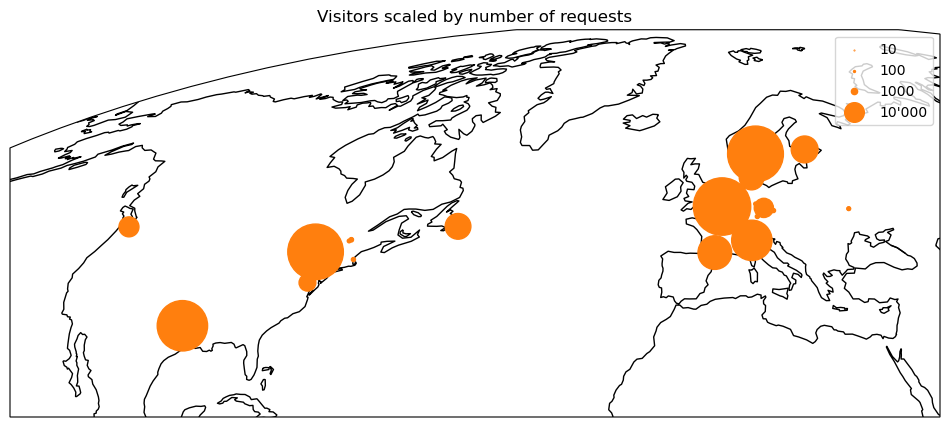

In [17]:
pc = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_extent([-120, 40, 20, 70])
ax.coastlines(zorder=-5)
scale_fac=50
plt.title("Visitors scaled by number of requests")
ax.scatter(df_vis["lon"], df_vis["lat"], s=df_vis["counts"]/scale_fac, transform=pc, color="C1")
ax.scatter(1000,10000, zorder=-10, s=10/scale_fac, label="10",  transform=pc,color="C1")
ax.scatter(1000,10000, zorder=-10, s=100/scale_fac, label="100",  transform=pc,color="C1")
ax.scatter(1000,10000, zorder=-10, s=1000/scale_fac, label="1000",  transform=pc,color="C1")
ax.scatter(1000,10000, zorder=-10, s=10000/scale_fac, label="10'000",  transform=pc,color="C1")

ax.legend()